# **MISE EN PLACE D'UN CNN DE CLASSIFICATION DES IMAGES DE LA NATURE**

#**1- Context**

Ce projet consiste à construire, entraîner et évaluer un modèle de classification d'images pour catégoriser des images en 8 classes différentes.


Le modèle prend en entrée des images (normalisées et redimensionnées) et les classe dans l'une des 8 catégories (comme "cat", "dog", "person", etc.).


#**2- DataSet**

## 1. Lire les fichiers d'image
La première étape consiste à lire les fichiers d'image à partir de Kaggle. Cela permet de charger les images brutes dans le programme pour les étapes suivantes de prétraitement.

Aussi j'ai effectuer une visualisation de tout les types d'images afin de verifier que le dataset est parfaitement charger et que les categories sont biens respectées.

In [1]:
# Monter le drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installation du package Kaggle
! pip install -q kaggle
# Creation d'un dossier kaggle
! mkdir ~/.kaggle/
# Copier Kaggle.json
! cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/
# Donner les droits a Kaggle
! chmod 600 ~/.kaggle/kaggle.json
# Téléchargement de la base de données
! kaggle datasets download -d prasunroy/natural-images
# dezip
! unzip natural-images.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: natural_images/cat/cat_0204.jpg  
  inflating: natural_images/cat/cat_0205.jpg  
  inflating: natural_images/cat/cat_0206.jpg  
  inflating: natural_images/cat/cat_0207.jpg  
  inflating: natural_images/cat/cat_0208.jpg  
  inflating: natural_images/cat/cat_0209.jpg  
  inflating: natural_images/cat/cat_0210.jpg  
  inflating: natural_images/cat/cat_0211.jpg  
  inflating: natural_images/cat/cat_0212.jpg  
  inflating: natural_images/cat/cat_0213.jpg  
  inflating: natural_images/cat/cat_0214.jpg  
  inflating: natural_images/cat/cat_0215.jpg  
  inflating: natural_images/cat/cat_0216.jpg  
  inflating: natural_images/cat/cat_0217.jpg  
  inflating: natural_images/cat/cat_0218.jpg  
  inflating: natural_images/cat/cat_0219.jpg  
  inflating: natural_images/cat/cat_0220.jpg  
  inflating: natural_images/cat/cat_0221.jpg  
  inflating: natural_images/cat/cat_0222.jpg  
  inflating: natural_images/c

Chargement de toutes les librairies utiliser lors de l'implementation et l'entrainement du CNN.

In [4]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from keras import layers, models
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
# Paramètres du dataset
path = '/content/natural_images/'
data = Path(path)
class_names = os.listdir(path) # Liste des catégories
image_label = {name: idx for idx, name in enumerate(class_names)}  # Map catégorie -> index
image_dict = {subdir.name: list(subdir.glob("*")) for subdir in data.iterdir() if subdir.is_dir()} # Map catégorie -> images

Ici le code pour l'affichage des images par categories

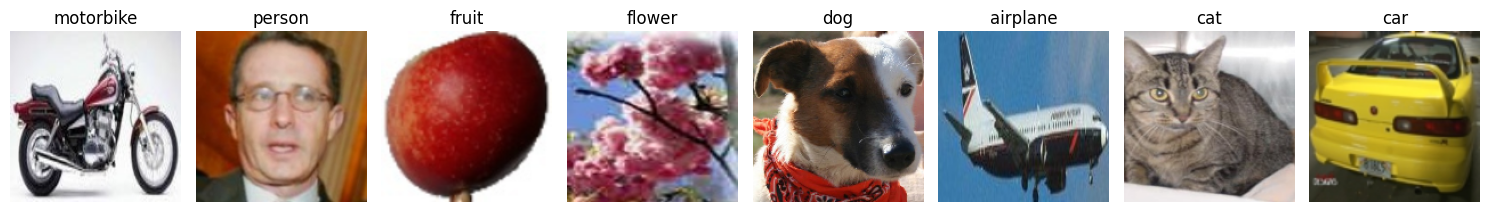

In [6]:
def display_sample_images(image_dict):
    plt.figure(figsize=(15, 10))

    for idx, (class_name, images) in enumerate(image_dict.items()):
        # Charger une image de la classe
        img = cv2.imread(str(images[0]))  # Première image de la classe
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB pour matplotlib
        img_resized = cv2.resize(img, (150, 150))  # Redimensionner pour un affichage uniforme

        # Afficher l'image
        plt.subplot(1, len(image_dict), idx + 1)
        plt.imshow(img_resized)
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
display_sample_images(image_dict)

## 2. Décoder le contenu image en grilles de pixels RGB
Une fois que les images sont lues, nous devons les décoder à partir de leur format compressé en grilles de pixels RGB (Rouge, Vert, Bleu). Cela transforme l'image en une matrice de valeurs numériques représentant les couleurs.

## 3. Convertir ces grilles en tableaux de nombres à virgule flottante
Les réseaux de neurones travaillent mieux avec des nombres. J'ai donc convertir les grilles de pixels en tableaux de nombres à virgule flottante pour pouvoir les utiliser dans nos modèles de deep learning.

## 4. Rescaler les valeurs des pixels entre 0 et 255 à l'intervalle 0,1
Les réseaux de neurones préfèrent traiter des valeurs d'entrée petites et normalisées. Il a fallu rescaler les valeurs des pixels de leur intervalle original [0, 255] à l'intervalle [0, 1].

Cette étape de normalisation permet d'améliorer la performance et la stabilité du modèle d'apprentissage, en garantissant que les valeurs d'entrée sont petites et homogènes.

## 5. Division du dataset en 2 partie le Train et le Test

On utilise 30% des données pour tester le modèle (c'est-à-dire mesurer sa performance sur des données non vues pendant l'entraînement).

In [7]:
X, Y = [], []
for label_name, images in image_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resize_img = cv2.resize(img, (28, 28))
        X.append(resize_img)
        Y.append(image_label[label_name])


X = np.array(X)
Y = np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
X_train_scaled = X_train/255
X_test_scaled = X_test/255
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

(4829, 28, 28, 3) (2070, 28, 28, 3) (4829,) (2070,)


#**3- Entrainement**

Le modèle comporte environ **613,064 paramètres** ajustables, ce qui le rend suffisamment puissant pour traiter des tâches de classification modérées sans nécessiter de pré-entraînement.

1. **Structure du modèle :**
   - Le modèle est un réseau de neurones convolutifs (CNN), spécialement conçu pour traiter et extraire des caractéristiques à partir d'images.
   - Voici les principales couches du modèle :
     - **Couches convolutionnelles (Conv2D)** :
       - La première couche a 32 filtres avec une taille de kernel de 5x5.
       - La deuxième couche a 64 filtres avec une taille de kernel de 3x3.
       - Ces couches détectent des caractéristiques dans les images comme des bords, des textures, ou des motifs complexes.
     - **Couches de pooling (MaxPool2D)** :
       - Réduisent la taille des images tout en conservant les caractéristiques importantes pour diminuer la complexité du modèle.
     - **Couches de dropout (Dropout)** :
       - Réduisent le risque de surapprentissage (overfitting) en désactivant de manière aléatoire certains neurones pendant l'entraînement.
     - **Couches denses (Dense)** :
       - La couche finale est une couche avec 8 neurones (correspondant aux 8 classes) et utilise une activation `softmax` pour générer des probabilités de classification.

2. **Fonction de perte et optimisation :**
   - La **fonction de perte** utilisée est `categorical_crossentropy`, adaptée pour les problèmes de classification multi-classes avec labels one-hot encodés.
   - L'optimiseur **Adam** avec un taux d'apprentissage (`learning_rate=1e-4`) est utilisé pour ajuster les poids du modèle pendant l'entraînement.


In [8]:
# Definir le modèle

model = models.Sequential()
model.add(layers.Conv2D(filters=32, padding='same',kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64,kernel_size=(3, 3), activation=LeakyReLU(alpha=0.02)))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Dense(8, activation='softmax'))

optimi = optimizers.Adam(learning_rate=1e-4)

# Compiler le modèle
model.compile(
    optimizer=optimi,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 613,064 (2.34 MB)

 Trainable params: 613,064 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Entraînement du modèle
history=model.fit(X_train, Y_train, epochs=10, validation_split=0.2)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.2626 - loss: 56.5230 - val_accuracy: 0.6822 - val_loss: 4.2047
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5912 - loss: 7.3865 - val_accuracy: 0.7567 - val_loss: 1.9510
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.7033 - loss: 3.1987 - val_accuracy: 0.7774 - val_loss: 1.3020
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7513 - loss: 1.8502 - val_accuracy: 0.7930 - val_loss: 1.0821
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.7482 - loss: 1.4717 - val_accuracy: 0.7961 - val_loss: 0.8976
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7951 - loss: 0.9858 - val_accuracy: 0.7992 - val_loss: 0.7954
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7978 - loss: 0.8371 - val_accuracy: 0.8126 - val_loss: 0.7341
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8243 - loss: 0.6932 - val_ac

Ici nous evaluons

In [14]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test accuracy:', accuracy)
y_predicted = model.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8357 - loss: 0.7651
Test accuracy: 0.8420289754867554
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


### **Interprétation des résultats :**

Une précision de 84.2% est un bon résultat pour un modèle simple sans pré-entraînement.
   - Le modèle a été évalué sur les données de test.
   - Résultats obtenus :
     - **Précision (accuracy) : 0.8420**  
       - Cela signifie que le modèle classe correctement environ 84% des images de test.
     - **Perte (loss) : 0.7651**  
       - Indique l'erreur moyenne dans les prédictions du modèle . Bien qu'une perte de 0.7651 soit acceptable, elle pourrait être encore améliorée.

   


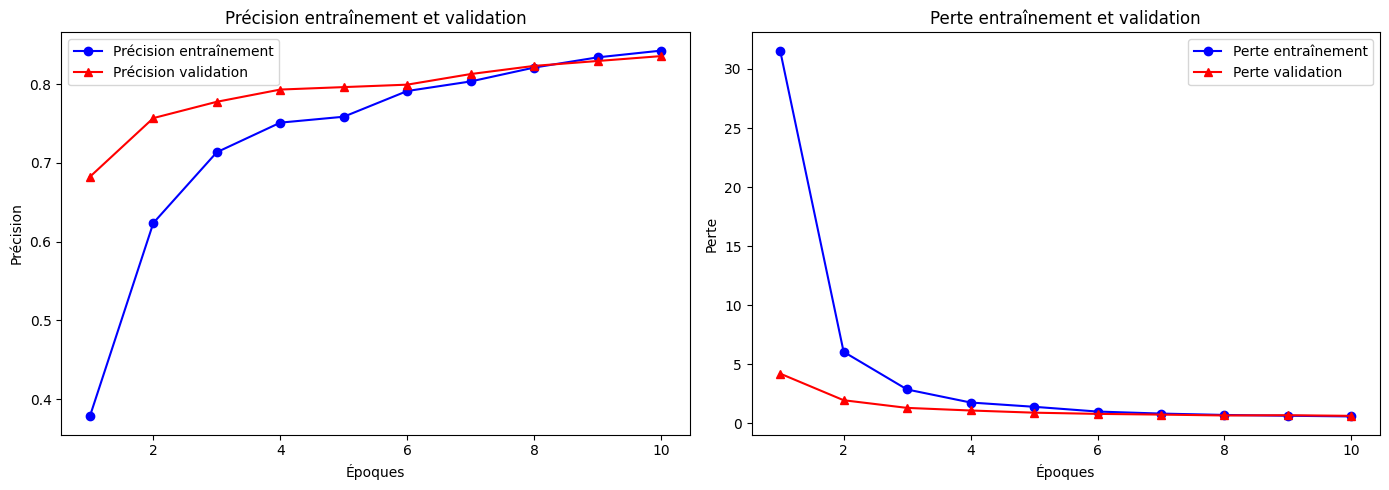

In [15]:
# Récupérer les données de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


# Tracer la courbe de précision
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Précision entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_acc, 'r^-', label='Précision validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Précision entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Tracer la courbe de perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Perte entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_loss, 'r^-', label='Perte validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Perte entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

Les courbes montres une bonnes correlation du modèle et on peut voir qu'il n'y a pas de cas d'overfitting entre les deux.

<Axes: xlabel='Predicted label', ylabel='True label'>

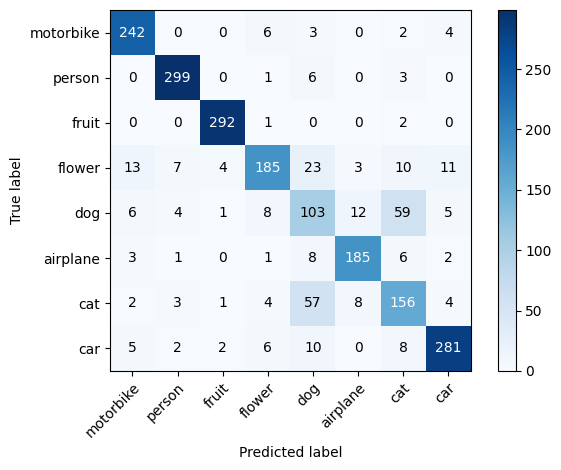

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes=None, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=range(cm.shape[1]),
           yticks=range(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

y_true =  np.argmax(Y_test, axis=1)
y_pred = np.argmax(y_predicted, axis=1)

plot_confusion_matrix(y_true, y_pred,class_names)

La matrice de confusion est tres concentre sur la diagonale ce qui implique les predictions sont pour la plus par exact.

#4- **Data Augmentation**

a data augmentation est une technique utilisée en apprentissage automatique et en vision par ordinateur pour augmenter la taille du jeu de données d'entraînement. Elle permet d'améliorer la performance des modèles en générant de nouvelles données à partir des données existantes. Voici les principaux points à retenir :

- **Définition** :
  - La data augmentation consiste à appliquer des transformations diverses aux images d'entraînement pour créer de nouvelles images.
  
- **Objectifs** :
  - **Augmenter la diversité des données** : Générer des variations des images existantes pour mieux représenter les différents scénarios possibles.
  - **Réduire le surapprentissage** : Enrichir le jeu de données pour éviter que le modèle ne mémorise les données d'entraînement plutôt que d'apprendre à généraliser.
  - **Améliorer la robustesse du modèle** : Entraîner le modèle à reconnaître les objets dans des conditions variées (éclairage, rotation, échelle, etc.).

- **Techniques courantes de data augmentation** :
  - **Rotation** : Tourner les images d'un certain angle.
  - **Translation** : Déplacer les images horizontalement ou verticalement.
  - **Miroir/Flip** : Inverser les images horizontalement ou verticalement.
  - **Zoom** : Agrandir ou rétrécir les images.
  - **Recadrage/Cropping** : Découper une partie de l'image et l'utiliser comme nouvelle image.
  - **Changement de luminosité/contraste** : Modifier les niveaux de luminosité et de contraste des images.
  - **Ajout de bruit** : Introduire du bruit aléatoire pour simuler des imperfections dans les images.

- **Avantages** :
  - **Meilleure généralisation** : Permet au modèle de mieux généraliser sur des données nouvelles et non vues.
  - **Coût efficace** : Générer des données augmentées est souvent moins coûteux que de collecter de nouvelles données réelles.
  
- **Limitations** :
  - **Complexité computationnelle** : La génération de données augmentées peut augmenter le temps d'entraînement.
  - **Qualité des transformations** : Les transformations doivent être réalistes et pertinentes pour ne pas introduire de biais dans l'entraînement.


In [18]:
# Préparation des DataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Pas d'augmentation pour les données de test


# Générateurs à partir des tableaux numpy
train_generator = train_datagen.flow(
    X_train, Y_train,
    batch_size=32
)

test_generator = test_datagen.flow(
    X_test, Y_test,
    batch_size=32
)

# Affichage des dimensions pour vérification
print(f"Taille des données d'entraînement : {X_train.shape}, {Y_train.shape}")
print(f"Taille des données de test : {X_test.shape}, {Y_test.shape}")

Taille des données d'entraînement : (4829, 28, 28, 3), (4829, 8)
Taille des données de test : (2070, 28, 28, 3), (2070, 8)


Nous avons repris le modele prcedent plus une couche de Conv2D de filtre 128 et MaxPooling.

In [19]:
# Definir le modèle

model1 = models.Sequential()
model1.add(layers.Conv2D(filters=32, padding='same',kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model1.add(layers.MaxPool2D(pool_size=(2, 2)))
model1.add(layers.Conv2D(filters=64,kernel_size=(3, 3), activation=LeakyReLU(alpha=0.02)))
model1.add(layers.MaxPool2D(pool_size=(2, 2)))
model1.add(layers.Conv2D(filters=128,kernel_size=(3, 3), activation=LeakyReLU(alpha=0.02)))
model1.add(layers.MaxPool2D(pool_size=(2, 2)))
model1.add(layers.Dropout(rate=0.25))
model1.add(layers.Flatten())
model1.add(layers.Dense(256))
model1.add(layers.Dropout(rate=0.25))
model1.add(layers.Dense(8, activation='softmax'))

optimi = optimizers.Adam(learning_rate=1e-4)

# Compiler le modèle
model1.compile(
    optimizer=optimi,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228,168 (891.28 KB)

 Trainable params: 228,168 (891.28 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Définir les callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte sur les données de validation
    patience=10,  # Arrêter si pas d'amélioration après 10 epochs
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Sauvegarder le meilleur modèle dans ce fichier
    save_best_only=True,  # Ne sauvegarder que le meilleur modèle
    monitor='val_loss',  # Basé sur la perte de validation
    mode='min',  # Chercher à minimiser la perte
    verbose=1  # Afficher des informations pendant l'entraînement
)

# Entraînement du modèle
history1 = model1.fit(
    train_generator,  # Générateur pour les données d'entraînement
    steps_per_epoch=len(X_train) // 32,  # Nombre de lots par epoch
    validation_data=test_generator,  # Générateur pour les données de test
    validation_steps=len(X_test) // 32,  # Nombre de lots pour la validation
    epochs=30,  # Nombre total d'epochs
    callbacks=[early_stopping, model_checkpoint]  # Liste des callbacks
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2112 - loss: 2.0024
Epoch 1: val_loss improved from inf to 1.51373, saving model to best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.2116 - loss: 2.0015 - val_accuracy: 0.4912 - val_loss: 1.5137
Epoch 2/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3750 - loss: 1.6352
Epoch 2: val_loss did not improve from 1.51373
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.3750 - loss: 1.6352 - val_accuracy: 0.4545 - val_loss: 1.6402
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4255 - loss: 1.5704
Epoch 3: val_loss improved from 1.51373 to 1.18587, saving model to best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.4257 - loss: 1.5700 - val_accuracy: 0.6104 - val_loss: 1.1859
Epoch 4/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4062 - loss: 1.6046
Epoch 4: val_loss did not improve from 1.18587
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - accuracy: 0.4062 - loss: 1.6046 - val_accuracy: 0.5000 - val_loss: 1.4260
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5017 - loss: 1.3371
Epoch 5: val_loss improved from 1.18587 to 1.04459, saving model to best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.5019 - loss: 1.3368 - val_accuracy: 0.6279 - val_loss: 1.0446
Epoch 6/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.5312 - loss: 1.1204
Epoch 6: val_loss did not improve from 1.04459
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/ste

In [21]:
model1.evaluate(train_generator)
y_predicted = model1.predict(test_generator)

151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7235 - loss: 0.7596
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Une précision de 72.3% est un bon résultat pour un modèle simple sans pré-entraînement.
   - Le modèle a été évalué sur les données de test.
   - Résultats obtenus :
     - **Précision (accuracy) : 0.7235**  
       - Cela signifie que le modèle classe correctement environ 72% des images de test.
     - **Perte (loss) : 0.7596**  
       - Indique l'erreur moyenne dans les prédictions du modèle . Bien qu'une perte de 0.7596 soit acceptable, elle pourrait être encore améliorée.

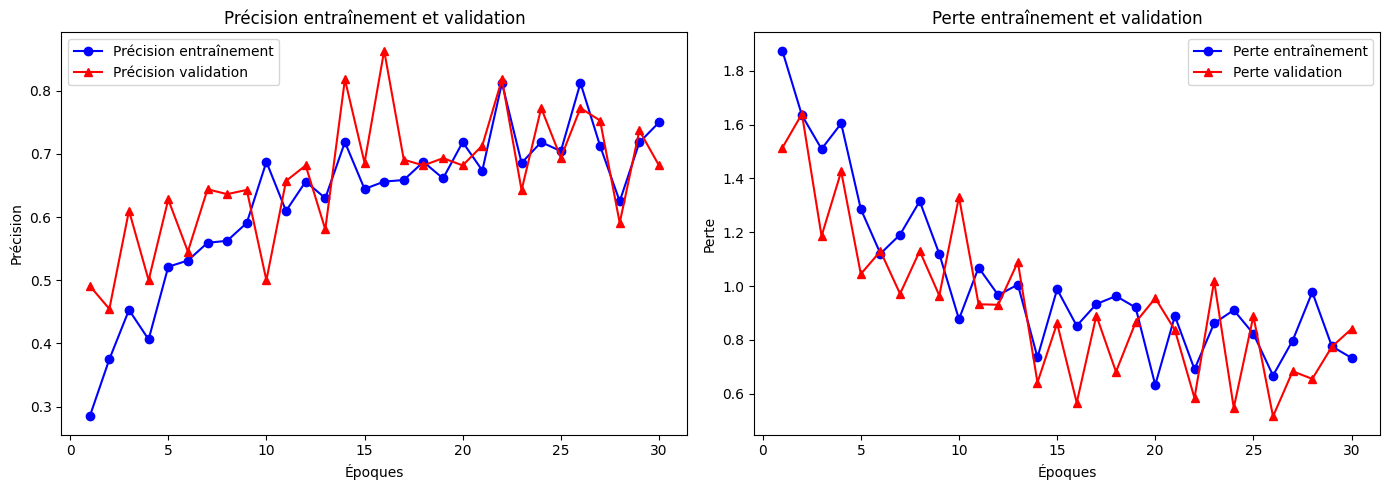

In [22]:
# Récupérer les données de l'historique
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)


# Tracer la courbe de précision
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Précision entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_acc, 'r^-', label='Précision validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Précision entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Tracer la courbe de perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Perte entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_loss, 'r^-', label='Perte validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Perte entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

Les courbes sont moins performantes que le modèle precedent

<Axes: xlabel='Predicted label', ylabel='True label'>

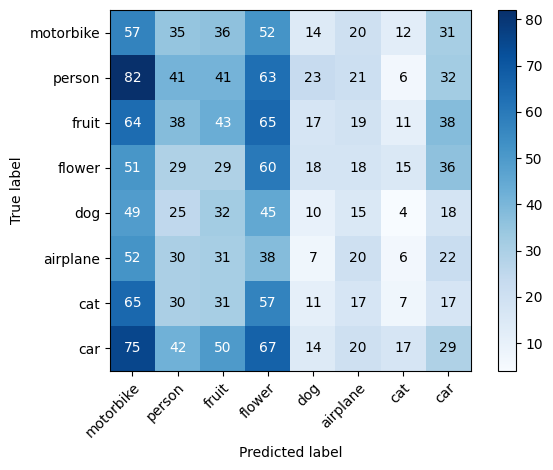

In [23]:
y_true =  np.argmax(Y_test, axis=1)
y_pred = np.argmax(y_predicted, axis=1)

plot_confusion_matrix(y_true, y_pred,class_names)

La matrice de confusion est plus dispersé demontrant que le modèle ne predit pas tres bien les classes

#**4- Forces et faiblesses**

### **Forces du modèle :**
1. **Simplicité :**
   - Le modèle est simple, avec une architecture directe, ce qui le rend facile à comprendre et à entraîner.
2. **Performance décente :**
   - Avec une précision de 84.2% sur les données de test, il donne des résultats acceptables pour un problème de classification multi-classes.
3. **Régularisation :**
   - Les couches de **Dropout** réduisent le surapprentissage.
4. **Optimiseur Adam :**
   - Un bon choix pour une convergence rapide et stable.


### **Faiblesses du modèle :**
1. **Architecture basique :**
   - Manque de profondeur et de complexité pour capturer des caractéristiques plus complexes dans les images.
2. **Pas de mécanisme avancé :**
   - Aucun mécanisme comme des couches de normalisation (BatchNorm) ou des augmentations de données sophistiquées.
3. **Perte encore élevée :**
   - Une perte de 0.7651 indique que le modèle ne minimise pas l'erreur de manière optimale.
4. **Pas d'ajustement des hyperparamètres :**
   - Le modèle utilise des valeurs par défaut (par exemple, taille de kernel, taux de dropout) sans exploration approfondie.
5. **Images redimensionnées en 28x28 :**
   - Une résolution très basse peut limiter la capture de détails importants pour certaines classes.




#**5- Perspective Amélioration**

1. **Augmenter la profondeur :** Ajouter plus de couches convolutionnelles et de pooling.  
2. **Batch Normalization :** Stabiliser et accélérer l'entraînement.  
3. **Augmentations de données :** Rotation, zoom, translation, etc.  
4. **Résolution plus élevée :** Passer à 64x64 ou 128x128 au lieu de 28x28.  
5. **Optimisation :** Ajuster les hyperparamètres (learning rate, dropout).  
6. **Architectures avancées :** Inspirer des modèles comme VGG ou ResNet.  
7. **Analyse des erreurs :** Étudier les prédictions incorrectes pour affiner le modèle.  